In [1]:
# Python library imports
# ------------------------
import datetime as dt

%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
import pickle
from lightgbm import LGBMRegressor
import sys
import csv


sys.path.append( '/home/tonyb/Gdrive/MinicondaProjects/oxaria/qoax/' )
from ml_utils import load_no24_training, no2_feature_gen, rushhour

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
# ----------------
data_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/'
rf_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/q12021/oct_update/no2_v3/notebooks/rf/'
#pngs = rf_home + 'pngs/'


In [2]:
# Read the saved model to avoid all the working above
# -----------------------------------------------------
model = pickle.load(
    open(rf_home + "LGBM_model_no2_jun_aug_val_c2_SH_xt_14jun_norm.sav", "rb")
)


In [3]:
# Load data for correction (deploying to full dataset)
# Load baseline adjusted gases data
# -----------------------------------
gases = pd.read_feather(
    data_home
    + "jun_to_sept_2021/oxaria_gases_536_stable15_bl_adjusted_ratified_2021_oct_update_transients.ftr"
).set_index(["tag", "rec"])
#                                 q12021/oxaria_gases_536_stable15_bl_adjusted_ratified+2021_sept_update_transients_v2.ftr
gases.rename(
    columns={"val.sht.tmp": "val.sht.tmp_g", "val.sht.hmd": "val.sht.hmd_g"},
    inplace=True,
)

auto_merged = pd.read_feather(
    data_home + "jun_to_sept_2021/auto_merged_ratified+2021_oct_update.ftr"
)
gases.info()



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 655655 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-10-01 00:00:00+0000', tz='UTC'))
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   val.no2.wev          655655 non-null  float32
 1   val.no2.cnc          654151 non-null  float32
 2   val.no2.aev          655655 non-null  float32
 3   val.no2.wec          654151 non-null  float32
 4   val.sht.hmd_g        654151 non-null  float32
 5   val.sht.tmp_g        654151 non-null  float32
 6   val.no2.cnc_1        641891 non-null  float32
 7   name                 655655 non-null  object 
 8   mag_hmd_s20          654149 non-null  float32
 9   mag_tmp_s20          654149 non-null  float32
 10  mean_hmd_s20         654149 non-null  float32
 11  mean_tmp_s20         654149 non-null  float32
 12  exg.vb20.no2.cnc     198639 non-null  float32
 13

In [4]:
# Feature engineering & prep on full dataset
# Function to generate the remaining feature required by the correction model
# -----------------------------------------------------------------------------
def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = (
        df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        .dropna(axis=1, how="all")
        .pct_change(periods=1)
    )
    tmpdf1.columns = ["pc15_" + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = (
        df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        .dropna(axis=1, how="all")
        .pct_change(periods=2)
    )
    tmpdf2.columns = ["pc30_" + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = (
        df.merge(tmpdf1, left_index=True, right_index=True, how="left")
        .merge(tmpdf2, left_index=True, right_index=True, how="left")
        .set_index(["tag", "rec"])
    )
    return df


def rushhour(df):
    # calc integer flags for hour of observation
    df["hour"] = df.index.get_level_values(1).hour
    # and day of week
    df["day"] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(7, 30, 0))
        & (df.index.get_level_values(1).time >= dt.time(9, 30, 0))
        & (df.index.get_level_values(1).weekday < 5),
        "rushhour",
    ] = 1
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(16, 0, 0))
        & (df.index.get_level_values(1).time >= dt.time(18, 0, 0))
        & (df.index.get_level_values(1).weekday < 5),
        "rushhour",
    ] = 2
    df["rushhour"] = np.where(df["rushhour"] >= 1, df["rushhour"], 0).astype(
        np.int32
    )
    return df


In [6]:
# Add the features needed by the LGDM model
# ---------------------------------------
tmp_list = []
for tag, dat in gases.reset_index().groupby("tag"):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
gases1 = pd.concat(tmp_list)

# Subset the df to include only cols needed by model
# ----------------------------------------------------
gases2 = gases1.loc[
    :,
    [
        "val.no2.wev",
        "val.no2.aev",
        "val.no2.wec",
        "val.sht.hmd_g",
        "val.sht.tmp_g",
        "val.no2.cnc_1_c1",
        "pc15_val.no2.wev",
        "pc15_val.no2.aev",
        "pc15_val.no2.wec",
        "pc15_val.sht.hmd_g",
        "pc15_val.sht.tmp_g",
        "pc15_val.no2.cnc_1_c1",
        "pc30_val.no2.wev",
        "pc30_val.no2.cnc",
        "pc30_val.no2.aev",
        "pc30_val.no2.wec",
        "pc30_val.sht.hmd_g",
        "pc30_val.sht.tmp_g",
        "pc30_val.no2.cnc_1_c1",
        "hour",
        "day",
        "rushhour",
    ],
]

# Drop weirdness in some columns
gases2 = gases2.replace([np.inf, -np.inf], np.nan).dropna(axis=0).sort_index()


# Normalise the data inputs, load the LGBM model & run
# -----------------------------------------------------
norm = Normalizer()
gases2_norm = pd.DataFrame(norm.fit_transform(gases2))
gases2_norm.columns = gases2.columns
gases2_norm.index = gases2.index

# calc predicted vals & merge with input
corrected_no2_vals = pd.concat(
    [
        gases2.reset_index(),
        pd.DataFrame(
            model.predict(gases2_norm), columns=["val.no2.cnc_1_lgbm_norm"]
        ),
    ],
    axis=1,
    join="outer",
).set_index(["tag", "rec"])

# Merge with subset
gases = gases.merge(
    corrected_no2_vals["val.no2.cnc_1_lgbm_norm"],
    on=["tag", "rec"],
    how="left",
)


In [8]:
# Correct for non-unity slope & non-zero intercept terms
# Correct for non-unity regressions terms & save
# -----------------------------------------------
gases["val.no2.cnc_1_lgbm_norm_cor"] = (gases["val.no2.cnc_1_lgbm_norm"] - 3.151) / 0.762

# Get rid of the typos
# ----------------------
mydict = {"Jahlul": "Ahlul", "Road": "Rd", "Street": "St", "Mosque": "Centre"}
gases["name"].replace(mydict, inplace=True, regex=True)
gases.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 655655 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-10-01 00:00:00+0000', tz='UTC'))
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   val.no2.wev                  655655 non-null  float32
 1   val.no2.cnc                  654151 non-null  float32
 2   val.no2.aev                  655655 non-null  float32
 3   val.no2.wec                  654151 non-null  float32
 4   val.sht.hmd_g                654151 non-null  float32
 5   val.sht.tmp_g                654151 non-null  float32
 6   val.no2.cnc_1                641891 non-null  float32
 7   name                         655655 non-null  object 
 8   mag_hmd_s20                  654149 non-null  float32
 9   mag_tmp_s20                  654149 non-null  float32
 10  mean_hmd_s20                 654149 non-null  float32
 

In [9]:
# Set corrected obs to St Ebbes baseline where its below St Ebbes baseline
#--------------------------------------------------------------------------
gases["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
     gases["val.no2.cnc_1_lgbm_norm_cor"] < gases["no2_ppb_s_bl"],
     gases["no2_ppb_s_bl"],
     gases["val.no2.cnc_1_lgbm_norm_cor"],
)

# Set corrected obs to nominal low conc where its still low
#-----------------------------------------------------------
gases["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
    gases["val.no2.cnc_1_lgbm_norm_cor_blc"] < 0.5,
    0.5,
    gases["val.no2.cnc_1_lgbm_norm_cor_blc"],
)

display(gases.groupby("name")[["val.no2.cnc_1_lgbm_norm_cor"]].describe(),
gases.groupby("name")[["val.no2.cnc_1_lgbm_norm_cor_blc"]].describe())

val.no2.cnc_1_lgbm_norm_cor                        \
                                           count       mean        std   
name                                                                     
Ahlul Bayt Centre                        40525.0  15.738073   9.871905   
County Hall                              26410.0  16.216492  10.509691   
Divinity Rd                              39391.0   4.153748   8.483305   
High St                                  25525.0  18.694619  18.793193   
Jesus College                            55135.0   3.886030   9.287616   
John Radcliffe                           24635.0   4.379961  10.934593   
New Marston                              47714.0  15.062645   8.413421   
Said Business School                     34587.0   7.753609  10.306784   
South Parks Rd                           36807.0  14.518704   7.240477   
Spare                                    23085.0  12.504914   9.503051   
Speedwell St                             21352.0  19.145594  10.541204   
St Ebbes                                 42594.0   5.893300   6.781605   
St Giles                                 40406.0  14.166415  10.160735   
The Plain                                52264.0   9.344291   8.864252   
Warneford Hospital                       41451.0   7.463599   9.120720   
Windmill School                          18000.0   0.608427   6.743805   
Worcester College                        48433.0  15.565587  10.182665   

                                                                              
                            min        25%        50%        75%         max  
name                                                                          
Ahlul Bayt Centre    -14.514319   9.542998  15.249572  21.524290  117.711099  
County Hall          -21.335164   8.933383  15.097416  22.233893  114.317986  
Divinity Rd          -38.318299  -0.595014   2.267364   6.779090   84.479082  
High St              -18.811384   6.218166  14.173312  25.816831  418.883403  
Jesus College        -20.984796  -0.868877   1.287294   5.164983  179.523096  
John Radcliffe       -21.246620  -0.904101   1.900657   5.795415  185.843977  
New Marston          -29.809846   9.829816  14.254977  19.017066   98.016245  
Said Business School -23.595166   1.064970   5.045639  11.717844  116.827518  
South Parks Rd       -26.591818  10.252509  13.991728  18.304594  101.270697  
Spare                -30.920756   5.738502  11.030657  17.527774   93.261118  
Speedwell St          -9.502731  12.180911  17.656174  24.355851  132.178062  
St Ebbes             -19.957804   1.682113   3.901351   7.920285  115.557924  
St Giles             -26.146889   7.442798  13.290630  19.409951  143.939969  
The Plain            -25.433049   3.362287   7.181896  12.902707  174.543264  
Warneford Hospital   -18.503645   1.054664   4.554269  12.099574  164.183622  
Windmill School      -30.929734  -2.861732  -0.102197   3.112913  122.840285  
Worcester College    -22.257585   8.813724  14.258925  20.634305  147.159536

val.no2.cnc_1_lgbm_norm_cor_blc                        \
                                               count       mean        std   
name                                                                         
Ahlul Bayt Centre                            40525.0  15.885856   9.617165   
County Hall                                  26410.0  16.305918  10.358914   
Divinity Rd                                  39391.0   5.401772   7.460237   
High St                                      25525.0  18.891990  18.574134   
Jesus College                                55135.0   5.003991   8.607475   
John Radcliffe                               24635.0   5.761716  10.036254   
New Marston                                  47714.0  15.101759   8.336680   
Said Business School                         34587.0   8.371751   9.735403   
South Parks Rd                               36807.0  14.582207   7.092101   
Spare                                        23085.0  12.673711   9.261499   
Speedwell St                                 21352.0  19.165842  10.502422   
St Ebbes                                     42594.0   6.115564   6.566847   
St Giles                                     40406.0  14.321517   9.918558   
The Plain                                    52264.0   9.483944   8.708772   
Warneford Hospital                           41451.0   7.968390   8.640672   
Windmill School                              18000.0   3.106948   4.980785   
Worcester College                            48433.0  15.649037  10.044474   

                                                                        
                      min        25%        50%        75%         max  
name                                                                    
Ahlul Bayt Centre     0.5   9.542998  15.249572  21.524290  117.711099  
County Hall           0.5   8.933383  15.097416  22.233893  114.317986  
Divinity Rd           0.5   1.035719   2.452146   6.779090   84.479082  
High St               0.5   6.218166  14.173312  25.816831  418.883403  
Jesus College         0.5   0.876862   1.673485   5.164983  179.523096  
John Radcliffe        0.5   1.027957   2.154187   5.795415  185.843977  
New Marston           0.5   9.829816  14.254977  19.017066   98.016245  
Said Business School  0.5   1.517803   5.045639  11.717844  116.827518  
South Parks Rd        0.5  10.252509  13.991728  18.304594  101.270697  
Spare                 0.5   5.738502  11.030657  17.527774   93.261118  
Speedwell St          0.5  12.180911  17.656174  24.355851  132.178062  
St Ebbes              0.5   1.822955   3.901351   7.920285  115.557924  
St Giles              0.5   7.442798  13.290630  19.409951  143.939969  
The Plain             0.5   3.362287   7.181896  12.902707  174.543264  
Warneford Hospital    0.5   1.473124   4.554269  12.099574  164.183622  
Windmill School       0.5   0.768655   1.493758   3.112913  122.840285  
Worcester College     0.5   8.813724  14.258925  20.634305  147.159536

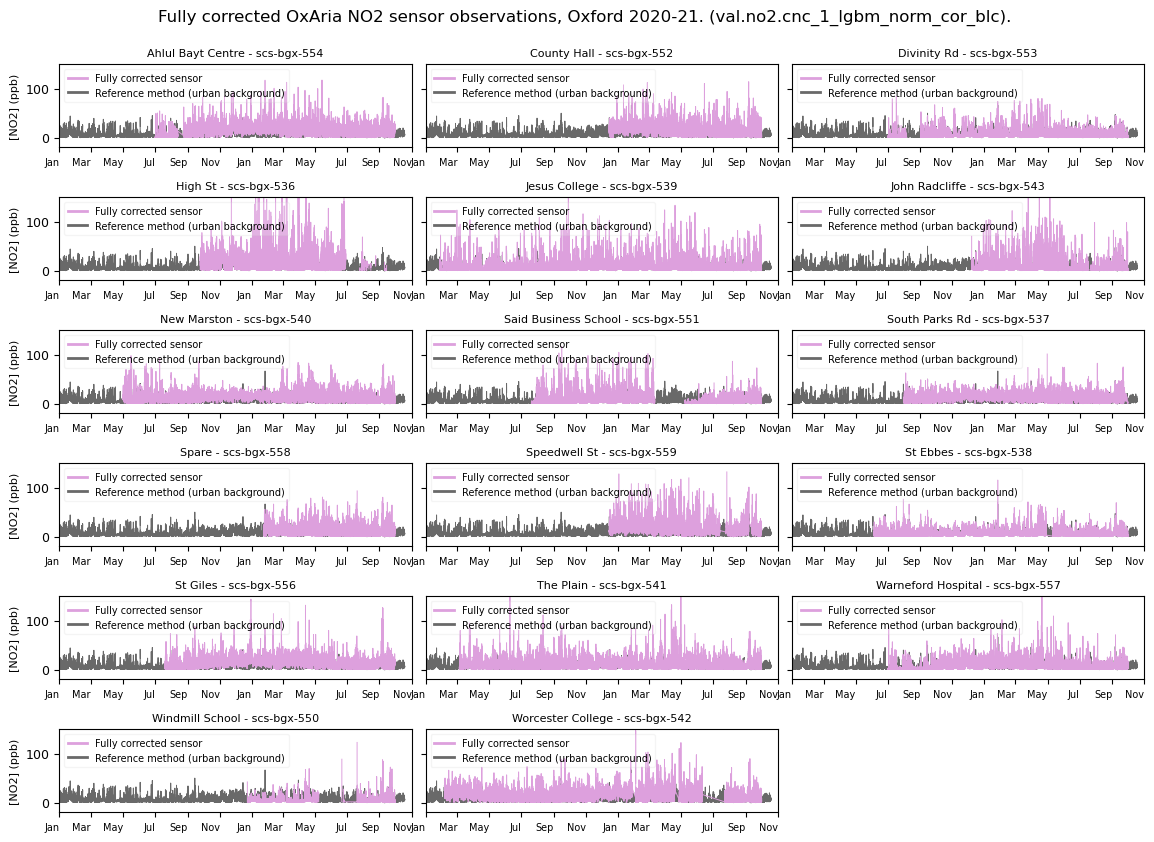

In [10]:
# Plot 15-min pm10
# -----------------
# x_ticks = pd.date_range('2020-01-01', periods=21, freq='MS')
# x_labels = [
#     'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
#     'A', 'M', 'J', 'J', 'A', 'S'
# ]

plt.style.use('default')
myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2021, 11, 1)

fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                         sharey=True, figsize=(14, 11))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fully corrected OxAria NO2 sensor observations, Oxford 2020-21. (val.no2.cnc_1_lgbm_norm_cor_blc).\n', y=0.93)
for idx, dat in gases.groupby('name'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    t_tag = dat['tag'].unique()
    title_txt = str(t_name[0]) + ' - ' + str(t_tag[0])
    dat.plot(x='rec', y='val.no2.cnc_1_lgbm_norm_cor_blc', c='plum', lw=0.7, marker='', ms=1, ls='-',
             label='Fully corrected sensor', ax=ax, legend=True, zorder=2, x_compat=True)
    auto_merged.reset_index().query('sitecode_s == "OX8"').plot(x='rec', y='no2_ppb_s', c='dimgrey', lw=0.7, marker='',
                                                                ms=0.1, ls='-',
                                                                label='Reference method (urban background)', ax=ax,
                                                                legend=True, zorder=1)
    ax.set_title(title_txt, fontsize=8)
    #ax.set_xticks(x_ticks)
    #ax.set_xticklabels(x_labels)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=7
    )
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(-20, 150)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')

    plt.subplots_adjust(wspace=0.04, hspace=0.6)

    leg = ax.legend(frameon=True, framealpha=0.2,
                    loc='upper left', ncol=1, fontsize=7)

    for line in leg.get_lines():
        line.set_linewidth(2.0)

fig.delaxes(axes_list[-1])

# plt.savefig(pngs+'oxaria0_pm10_15m_fullycorrected_sensor_ts202021.png')
plt.show()

# for ax in axes_list:
#     ax.remove()


In [13]:
# Save to an ftr file 
#---------------------
gases['val.no2.cnc_1_lgbm_norm_cor_blc_ug'] = gases['val.no2.cnc_1_lgbm_norm_cor_blc'] * 1.9125
gases.reset_index().to_feather(data_home+'jun_to_sept_2021/oxaria_gases_536_stable15_rat_full_norm_corr_blc_202021.ftr')
gases = pd.read_feather(data_home+'jun_to_sept_2021/oxaria_gases_536_stable15_rat_full_norm_corr_blc_202021.ftr').set_index(['tag','name','rec'])
gases.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 655655 entries, ('scs-bgx-536', 'High St', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', 'Speedwell St', Timestamp('2021-10-01 00:00:00+0000', tz='UTC'))
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   val.no2.wev                         655655 non-null  float32
 1   val.no2.cnc                         654151 non-null  float32
 2   val.no2.aev                         655655 non-null  float32
 3   val.no2.wec                         654151 non-null  float32
 4   val.sht.hmd_g                       654151 non-null  float32
 5   val.sht.tmp_g                       654151 non-null  float32
 6   val.no2.cnc_1                       641891 non-null  float32
 7   mag_hmd_s20                         654149 non-null  float32
 8   mag_tmp_s20                         654149 non-null  float32
 9   mean_hmd_s

In [3]:
gases = pd.read_feather(data_home+'jun_to_sept_2021/oxaria_gases_536_stable15_rat_full_norm_corr_blc_202021.ftr').set_index(['tag','name','rec'])
gases.head()

val.no2.wev  val.no2.cnc  \
tag         name    rec                                                   
scs-bgx-536 High St 2020-09-25 00:15:00+00:00     0.284314 -1886.685547   
                    2020-09-25 00:30:00+00:00     0.283953 -1888.198853   
                    2020-09-25 00:45:00+00:00     0.284208 -1887.843384   
                    2020-09-25 01:00:00+00:00     0.283667 -1887.250610   
                    2020-09-25 01:15:00+00:00     0.283602 -1893.280884   

                                               val.no2.aev  val.no2.wec  \
tag         name    rec                                                   
scs-bgx-536 High St 2020-09-25 00:15:00+00:00     0.271670    -0.000338   
                    2020-09-25 00:30:00+00:00     0.271637    -0.000640   
                    2020-09-25 00:45:00+00:00     0.271754    -0.000570   
                    2020-09-25 01:00:00+00:00     0.271336    -0.000451   
                    2020-09-25 01:15:00+00:00     0.272056    -0.001656   

                                               val.sht.hmd_g  val.sht.tmp_g  \
tag         name    rec                                                       
scs-bgx-536 High St 2020-09-25 00:15:00+00:00      73.198891       9.683333   
                    2020-09-25 00:30:00+00:00      72.821114       9.601111   
                    2020-09-25 00:45:00+00:00      73.252220       9.592222   
                    2020-09-25 01:00:00+00:00      72.476402       9.657304   
                    2020-09-25 01:15:00+00:00      72.530334       9.629213   

                                               val.no2.cnc_1  mag_hmd_s20  \
tag         name    rec                                                     
scs-bgx-536 High St 2020-09-25 00:15:00+00:00   -1886.685547       -0.040   
                    2020-09-25 00:30:00+00:00   -1888.198853       -0.050   
                    2020-09-25 00:45:00+00:00   -1887.843384        0.045   
                    2020-09-25 01:00:00+00:00   -1887.250610       -0.035   
                    2020-09-25 01:15:00+00:00   -1893.280884        0.020   

                                               mag_tmp_s20  mean_hmd_s20  ...  \
tag         name    rec                                                   ...   
scs-bgx-536 High St 2020-09-25 00:15:00+00:00       -0.005      0.000625  ...   
                    2020-09-25 00:30:00+00:00       -0.005     -0.000222  ...   
                    2020-09-25 00:45:00+00:00       -0.005     -0.000111  ...   
                    2020-09-25 01:00:00+00:00       -0.005     -0.000730  ...   
                    2020-09-25 01:15:00+00:00       -0.005      0.000674  ...   

                                               val.no2.cnc_1_c0_bl  \
tag         name    rec                                              
scs-bgx-536 High St 2020-09-25 00:15:00+00:00            -2.797178   
                    2020-09-25 00:30:00+00:00            -2.814219   
                    2020-09-25 00:45:00+00:00            -2.831261   
                    2020-09-25 01:00:00+00:00            -2.848303   
                    2020-09-25 01:15:00+00:00            -2.865345   

                                               no2_ppb_s_bl  no2_ppb_h_bl  \
tag         name    rec                                                     
scs-bgx-536 High St 2020-09-25 00:15:00+00:00      1.304847      2.077300   
                    2020-09-25 00:30:00+00:00      1.303923      2.075161   
                    2020-09-25 00:45:00+00:00      1.303000      2.073021   
                    2020-09-25 01:00:00+00:00           NaN           NaN   
                    2020-09-25 01:15:00+00:00           NaN           NaN   

                                               no2_1_c0_bl_offset1  \
tag         name    rec                                              
scs-bgx-536 High St 2020-09-25 00:15:00+00:00             4.102024   
                    2020-09-25 00:30:00+00:00             4.118143   
                    20

In [6]:
gases['val.no2.cnc_1_lgbm_norm_cor_blc_ug'].groupby('name').describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
Ahlul Bayt Centre,40525.0,30.381700,18.392829,0.95625,18.250984,29.164806,41.165204,225.122476
County Hall,26410.0,31.185068,19.811422,0.95625,17.085095,28.873807,42.522321,218.633148
Divinity Rd,39391.0,10.330888,14.267702,0.95625,1.980813,4.689730,12.965009,161.566244
High St,25525.0,36.130932,35.523032,0.95625,11.892242,27.106460,49.374689,801.114508
Jesus College,55135.0,9.570132,16.461795,0.95625,1.676998,3.200541,9.878030,343.337920
John Radcliffe,24635.0,11.019281,19.194335,0.95625,1.965968,4.119884,11.083732,355.426605
New Marston,47714.0,28.882115,15.943900,0.95625,18.799523,27.262644,36.370139,187.456068
Said Business School,34587.0,16.010973,18.618958,0.95625,2.902799,9.649785,22.410376,223.432628
South Parks Rd,36807.0,27.888470,13.563643,0.95625,19.607924,26.759180,35.007537,193.680208
